# 1. Import libraries and read dataset

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from pandasql import sqldf
import seaborn as sns
plt.style.use('seaborn')

In [3]:
# Import dataset from a csv file into a data frame
file = 'Raw_data_Food_Inspections.csv'
df = pd.read_csv(file)

In [4]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2079132,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517328.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,NaN,41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
1,2079129,JET'S PIZZA,JET'S PIZZA,2522268.0,Restaurant,Risk 2 (Medium),1025 W MADISON ST,CHICAGO,IL,60607.0,08/28/2017,License,Not Ready,NaN,41.881572,-87.653052,"(41.88157249576794, -87.65305233593274)"
2,2079125,ROOM 1520,ROOM 1520,2446638.0,Special Event,Risk 3 (Low),301 N JUSTINE ST,CHICAGO,IL,60607.0,08/28/2017,License Re-Inspection,Not Ready,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.886577,-87.665328,"(41.88657652150854, -87.66532812140231)"
3,2079123,MARRIOT MARQUIS CHICAGO,MARRIOT MARQUIS CHICAGO,2517338.0,Restaurant,Risk 1 (High),2121 S PRAIRIE AVE,CHICAGO,IL,60616.0,08/28/2017,License,Pass,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.853651,-87.620534,"(41.853650885040594, -87.62053358114167)"
4,2079105,CHARTWELLS,CICS WEST BELDEN CAMPUS,2549079.0,CHARTER SCHOOL,Risk 1 (High),2245 N MCVICKER AVE,CHICAGO,IL,60639.0,08/28/2017,License Re-Inspection,Pass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.921675,-87.776711,"(41.921675488910864, -87.7767113569357)"


In [5]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153810 entries, 0 to 153809
Data columns (total 17 columns):
Inspection ID      153810 non-null int64
DBA Name           153810 non-null object
AKA Name           151267 non-null object
License #          153795 non-null float64
Facility Type      149250 non-null object
Risk               153744 non-null object
Address            153810 non-null object
City               153651 non-null object
State              153802 non-null object
Zip                153712 non-null float64
Inspection Date    153810 non-null object
Inspection Type    153809 non-null object
Results            153810 non-null object
Violations         123012 non-null object
Latitude           153266 non-null float64
Longitude          153266 non-null float64
Location           153266 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 19.9+ MB


# 2. Remove redundant columns, regularize column names, clean missing values

### 2.1 Remove redundant columns 

In [6]:
# All facilities are in IL, except 8 missing data (153810 total entries - 153802 entries with state)
# so 'State' column is not very necessary
print(df['State'].value_counts())
df.drop(columns = ['State'], inplace=True)

# Our main target is to find the risk levels corresponding with the zip code. 
# The details of each violation are not important to our study.
df.drop(columns = ['Violations'], inplace=True)

# The information in 'Location' is duplicated with ‘Latitude’ and ‘Longitude’ 
df.drop(columns='Location', inplace=True)

# 'AKA name' is relevant to our use cases.
df.drop(columns='AKA Name', inplace=True)

IL    153802
Name: State, dtype: int64


### 2.2 Regularize column names

In [7]:
# After inspecting the colomn name, we noticed that there are some space in the columns' name.
# Clean up the columns' name and remove the spaces
df.columns = [each.split()[0] + "_" + each.split()[1] if len(each.split()) > 1 else each for each in df.columns]

# Separate the inspection_date into Year, Month and Day 
df['Year'] = pd.DatetimeIndex(df['Inspection_Date']).year
df['Month'] = pd.DatetimeIndex(df['Inspection_Date']).month
df['Day'] = pd.DatetimeIndex(df['Inspection_Date']).day

df.columns

Index(['Inspection_ID', 'DBA_Name', 'License_#', 'Facility_Type', 'Risk',
       'Address', 'City', 'Zip', 'Inspection_Date', 'Inspection_Type',
       'Results', 'Latitude', 'Longitude', 'Year', 'Month', 'Day'],
      dtype='object')

### 2.3 Check and clean missing values

In [8]:
# Check missing values
print('Missing values for each column in the Dataframe:')
df.isnull().sum().sort_values(ascending=False)

Missing values for each column in the Dataframe:


Facility_Type      4560
Longitude           544
Latitude            544
City                159
Zip                  98
Risk                 66
License_#            15
Inspection_Type       1
Day                   0
Month                 0
Year                  0
Results               0
Inspection_Date       0
Address               0
DBA_Name              0
Inspection_ID         0
dtype: int64

In [9]:
# Drop rows missing Facility_Type, Longitude, Latitude, Zip, Risk and Inspection_Type
df.dropna(subset=['Facility_Type'], inplace=True)
df.dropna(subset=['Longitude'], inplace=True)
df.dropna(subset=['Latitude'], inplace=True)
df.dropna(subset=['Zip'], inplace=True)
df.dropna(subset=['Risk'], inplace=True)
df.dropna(subset=['Inspection_Type'], inplace=True)
df.dropna(subset=['License_#'], inplace=True)
df.dropna(subset=['City'], inplace=True)

# Check missing values after handling the missing values
print('Missing values for each column in the Dataframe:')
df.isnull().sum().sort_values(ascending=False)

Missing values for each column in the Dataframe:


Day                0
Month              0
Year               0
Longitude          0
Latitude           0
Results            0
Inspection_Type    0
Inspection_Date    0
Zip                0
City               0
Address            0
Risk               0
Facility_Type      0
License_#          0
DBA_Name           0
Inspection_ID      0
dtype: int64

# 3. Check duplicates, correct datatype and decimal, trim strings and clustering, remove outliers

### 3.1 Check duplicates

In [10]:
# Column 'Inspection ID' is clean, with unique numbers each, and correct data type.
print('Total entries:', len(df))
print('Number of unique values in each column: ')
print(df.nunique().sort_values(ascending=False))


Total entries: 148538
Number of unique values in each column: 
Inspection_ID      148538
License_#           28521
DBA_Name            21151
Address             15851
Longitude           15062
Latitude            15062
Inspection_Date      1945
Facility_Type         435
Inspection_Type       105
Zip                    63
Day                    31
City                   17
Month                  12
Year                    8
Results                 7
Risk                    4
dtype: int64


In [11]:
# There is no duplicate since the number of unique inspection ID is equal to the total entries.
duplicates = df[df.duplicated()]

duplicates

,Inspection_ID,DBA_Name,License_#,Facility_Type,Risk,Address,City,Zip,Inspection_Date,Inspection_Type,Results,Latitude,Longitude,Year,Month,Day


### 3.2 correct datatype and decimal

In [24]:
# ‘Latitude’ and ‘Longitude’ should be rounded to four decimals.
df['Latitude'] = round(df['Latitude'], 4)
df['Longitude'] = round(df['Longitude'], 4)

# Column ‘zip’ and ‘License #’ should be converted to integer.
df['License_#'] = df['License_#'].replace(np.nan, 0)
df['License_#'] = df['License_#'].astype(int)

# If the facility's zipcode is missing, we are not able to locate it, 
# thus all rows without  zip code are removed, along with wrong zipcodes.
df['Zip'] = df['Zip'].astype(int)

# 'Inspection Date' Column should be datetime
pd.set_option('display.max_rows', 10)
pd.to_datetime(df['Inspection_Date'])

# Sort the dataframe by inspection date to make it more clear.
df.sort_values("Inspection_Date", inplace=True)
df.insert(0, 'Inspection_Date', df.pop('Inspection_Date'))
df.index = np.arange(0, len(df))
df.head(10)

,Inspection_Date,Inspection_ID,DBA_Name,License_#,Facility_Type,Risk,Address,City,Zip,Inspection_Type,Results,Latitude,Longitude,Year,Month,Day
0,01/02/2013,1146224,EL CASTILLO MEAT MARKET,66267,GROCERY STORE,Risk 1 (High),3704 W 55TH ST,CHICAGO,60632,Canvass,FAIL,41.7934,-87.7160,2013,1,2
1,01/02/2013,1202588,CHURCH'S CHICKEN # 1053,1273275,RESTAURANT,Risk 2 (Medium),1151 S INDEPENDENCE BLVD,CHICAGO,60624,Complaint,FAIL,41.8665,-87.7194,2013,1,2
2,01/02/2013,1202587,ADAM & ARAM CORPORATION,2137725,GROCERY STORE,Risk 3 (Low),5145 W DIVISION ST,CHICAGO,60651,Complaint,PASS,41.9021,-87.7552,2013,1,2
3,01/02/2013,1146223,LE PARIS BAKERY NO 2 INC,1095974,RESTAURANT,Risk 1 (High),5434 S PULASKI RD,CHICAGO,60632,Canvass,FAIL,41.7940,-87.7233,2013,1,2
4,01/02/2013,1286217,A MOTHER'S TOUCH DAYCARE,1738081,DAYCARE (2 - 6 YEARS),Risk 1 (High),1505 N PULASKI RD,CHICAGO,60651,Canvass,PASS,41.9083,-87.7263,2013,1,2
5,01/02/2013,1286216,A MOTHER'S TOUCH DAYCARE,1738084,DAYCARE (2 - 6 YEARS),Risk 1 (High),1505 N PULASKI RD,CHICAGO,60651,Canvass,PASS,41.9083,-87.7263,2013,1,2
6,01/02/2013,1202586,CHILDREN INTERNATIONAL ACADEMY,1820106,CHILDREN'S SERVICES FACILITY,Risk 1 (High),5858 W ROOSEVELT RD,CHICAGO,60644,Canvass,PASS,41.8656,-87.7716,2013,1,2
7,01/02/2013,1301080,SHAH MINI MART,2203628,GROCERY STORE,Risk 3 (Low),4234 W FULLERTON AVE,CHICAGO,60639,License,PASS,41.9245,-87.7331,2013,1,2
8,01/02/2013,1301083,CAPTAIN HOOKS FISH & CHICKEN,1169578,RESTAURANT,Risk 1 (High),8550 S COTTAGE GROVE AVE,CHICAGO,60619,Complaint,PASS,41.7388,-87.6050,2013,1,2
9,01/02/2013,1146222,SUBWAY,1356009,RESTAURANT,Risk 1 (High),5131 S PULASKI RD,CHICAGO,60632,Canvass,PASS,41.7995,-87.7232,2013,1,2


### 3.3 Trim strings and clustering

In [13]:
# Trim the strings
df['DBA_Name'] = df['DBA_Name'].str.strip()
df['Facility_Type'] = df['Facility_Type'].str.strip()

# Change to upper cases
df['DBA_Name'] = df['DBA_Name'].str.upper()
df['Facility_Type'] = df['Facility_Type'].str.upper()
df['Address'] = df['Address'].str.upper()
df['City'] = df['City'].str.upper()
df['Results'] = df['Results'].str.upper()
df['DBA_Name'].value_counts()

# Many names can be clustered, e.g: 'Subway' & 'Subway Sandwiches', 'MCDONALD'S' & 'MC DONALD'S'
df['DBA_Name'] = df['DBA_Name'].replace(["MC DONALD'S","McDONALD'S","MCDONALDS ","MCDONALD'S RESTAURANT","MCDONALDS","MC DONALDS","MCDONALDS RESTAURANT"],"MCDONALD'S")
df['DBA_Name'] = df['DBA_Name'].replace(['SUBWAY SANDWICHES',"SUBWAY SANDWICH","SUBWAY RESTAURANT",'SUBWAY SANDWICHES & SALADS',"SUBWAY SANDWICH & SALAD"],'SUBWAY')
df['DBA_Name'] = df['DBA_Name'].replace(['DUNKIN DONUTS/BASKIN ROBBINS','DUNKIN DONUTS BASKIN ROBBINS','DUNKIN DONUTS / BASKIN ROBBINS'],'DUNKIN DONUTS')
df['DBA_Name'] = df['DBA_Name'].replace(['KENTUCKY FRIED CHICKEN'],'KFC')
df['DBA_Name'] = df['DBA_Name'].replace(["POPEYES CHICKEN","POPEYE'S CHICKEN","POPEYE'S FRIED CHICKEN"],'POPEYES')
df['DBA_Name'] = df['DBA_Name'].replace(['7 - ELEVEN'],'7-ELEVEN')
df['DBA_Name'] = df['DBA_Name'].replace(['POTBELLY SANDWICH WORKS LLC'],'POTBELLY SANDWICH WORKS')
df['DBA_Name'] = df['DBA_Name'].replace(['STARBUCKS COFFEE'],'STARBUCKS')
df['DBA_Name'] = df['DBA_Name'].replace(["JIMMY JOHN'S","JIMMY JOHNS SANDWICH SHOPS"],"JIMMY JOHNS")

# City
df['City'] = df['City'].replace(["CCHICAGO","CHCHICAGO","CHCICAGO",'CHICAGOI','CHICAGOCHICAGO'],"CHICAGO")

### 3.4 Remove outliers

In [14]:
# Remove invalid results and only consider successful inspections
print('Original Results: ')
print(df['Results'].value_counts())
df = df[~df.Results.isin(["OUT OF BUSINESS", "NO ENTRY", "NOT READY", "BUSINESS NOT LOCATED"])]
print()
print('Results after removing outliers: ')
print(df['Results'].value_counts())

# Remove invalid risk type
print()
print('Original Risk type: ')
print(df['Risk'].value_counts())
df = df[df['Risk'] != 'All']
print()
print('Risk type after removing outlier: ')
print(df['Risk'].value_counts())

Original Results: 
PASS                    89797
FAIL                    29321
PASS W/ CONDITIONS      14460
OUT OF BUSINESS          9968
NO ENTRY                 4200
NOT READY                 756
BUSINESS NOT LOCATED       36
Name: Results, dtype: int64

Results after removing outliers: 
PASS                  89797
FAIL                  29321
PASS W/ CONDITIONS    14460
Name: Results, dtype: int64

Original Risk type: 
Risk 1 (High)      96324
Risk 2 (Medium)    27408
Risk 3 (Low)        9845
All                    1
Name: Risk, dtype: int64

Risk type after removing outlier: 
Risk 1 (High)      96324
Risk 2 (Medium)    27408
Risk 3 (Low)        9845
Name: Risk, dtype: int64


In [15]:
# Standard deviation are pretty small for both latitude and longitude,
# so there is no outlier for these two numerical columns
df.describe()[['Latitude', 'Longitude']]

,Latitude,Longitude
count,133577.000000,133577.000000
mean,41.879175,-87.675971
std,0.081144,0.059330
min,41.644700,-87.914400
25%,41.827300,-87.707300
50%,41.890700,-87.665800
75%,41.938900,-87.634200
max,42.021100,-87.525100


### 4. Data visualization to explain use cases

In [25]:
# Dataset after cleaning
df.head()

,Inspection_Date,Inspection_ID,DBA_Name,License_#,Facility_Type,Risk,Address,City,Zip,Inspection_Type,Results,Latitude,Longitude,Year,Month,Day
0,01/02/2013,1146224,EL CASTILLO MEAT MARKET,66267,GROCERY STORE,Risk 1 (High),3704 W 55TH ST,CHICAGO,60632,Canvass,FAIL,41.7934,-87.7160,2013,1,2
1,01/02/2013,1202588,CHURCH'S CHICKEN # 1053,1273275,RESTAURANT,Risk 2 (Medium),1151 S INDEPENDENCE BLVD,CHICAGO,60624,Complaint,FAIL,41.8665,-87.7194,2013,1,2
2,01/02/2013,1202587,ADAM & ARAM CORPORATION,2137725,GROCERY STORE,Risk 3 (Low),5145 W DIVISION ST,CHICAGO,60651,Complaint,PASS,41.9021,-87.7552,2013,1,2
3,01/02/2013,1146223,LE PARIS BAKERY NO 2 INC,1095974,RESTAURANT,Risk 1 (High),5434 S PULASKI RD,CHICAGO,60632,Canvass,FAIL,41.7940,-87.7233,2013,1,2
4,01/02/2013,1286217,A MOTHER'S TOUCH DAYCARE,1738081,DAYCARE (2 - 6 YEARS),Risk 1 (High),1505 N PULASKI RD,CHICAGO,60651,Canvass,PASS,41.9083,-87.7263,2013,1,2


In [17]:
# Export clean dataset
df.to_csv('Clean_food_inspection_data.csv')

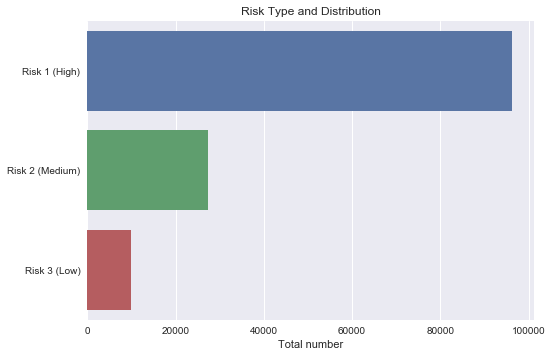

In [18]:
# Plot Risk Type
c2=sns.barplot(x=df['Risk'].value_counts()[:4],y=df['Risk'].value_counts()[:4].index)
c2.set_title('Risk Type and Distribution')
c2.set_ylabel('')
c2.set_xlabel('Total number')
plt.show()

In [ ]:
# Create separete dataframe for visualizing risk percentage distributions by Zipcode
risk_df = df.groupby(['Zip','Risk']).count()
risk_df.reset_index(level='Risk',inplace=True)
risk_dis = risk_df[['Risk','Inspection_ID']]
risk_dis['High_risk'] = risk_dis[risk_dis['Risk'] == 'Risk 1 (High)']['Inspection_ID']
risk_dis['Medium_risk'] = risk_dis[risk_dis['Risk'] == 'Risk 2 (Medium)']['Inspection_ID']
risk_dis['Low_risk'] = risk_dis[risk_dis['Risk'] == 'Risk 3 (Low)']['Inspection_ID']
risk_dis.reset_index(inplace=True)
risk_dis = risk_dis.groupby(['Zip']).mean()
risk_dis.drop(columns='Inspection_ID', inplace=True)
risk_dis.reset_index(inplace=True)
risk_dis.sort_values('High_risk', ascending=False)
risk_dis.fillna(0,inplace=True)
risk_dis['risk_sum'] = risk_dis['High_risk'] + risk_dis['Medium_risk'] + risk_dis['Low_risk']
risk_dis['High_risk_percent'] = risk_dis['High_risk'] / (risk_dis['risk_sum'])
risk_dis['Medium_risk_percent'] = risk_dis['Medium_risk'] / (risk_dis['risk_sum'])
risk_dis['Low_risk_percent'] = risk_dis['Low_risk'] / (risk_dis['risk_sum'])

risk_dis.head()

In [20]:
# Export the risk distribution dataset and plot choropleth map in Tableau
risk_dis.to_csv('Risk_distribution.csv')

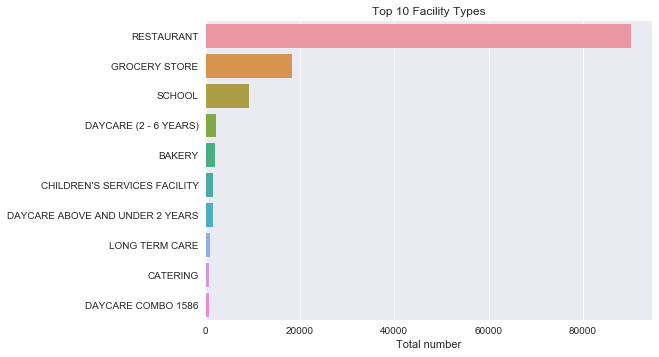

In [21]:
# Check top 10 facility types
c1=sns.barplot(x=df['Facility_Type'].value_counts()[:10],y=df['Facility_Type'].value_counts()[:10].index)
c1.set_title('Top 10 Facility Types')
c1.set_ylabel('')
c1.set_xlabel('Total number')
plt.show()

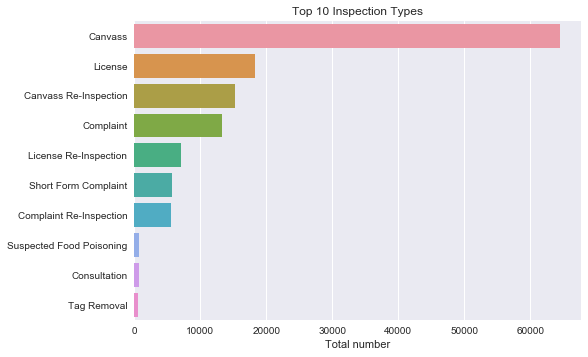

In [22]:
# Check top 10 inspection types
c3=sns.barplot(x=df['Inspection_Type'].value_counts()[:10],y=df['Inspection_Type'].value_counts()[:10].index)
c3.set_title('Top 10 Inspection Types')
c3.set_ylabel('')
c3.set_xlabel('Total number')
plt.show()